In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd

sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/utils')
sys.path.append('/Users/lorenzostigliano/Documents/University/Imperial/Summer Term/thesis-imperial/src/models')

from utils.analysis import *
from utils.getters import * 
from utils.plotters import * 
from utils.helpers import * 
from models_config.model_config_BreastMNIST import *


## Reproducibility

/var/folders/1j/5s36wz6s0jlb1k64vsq1k2zh0000gn/T/ipykernel_57872/3653773435.py:3: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


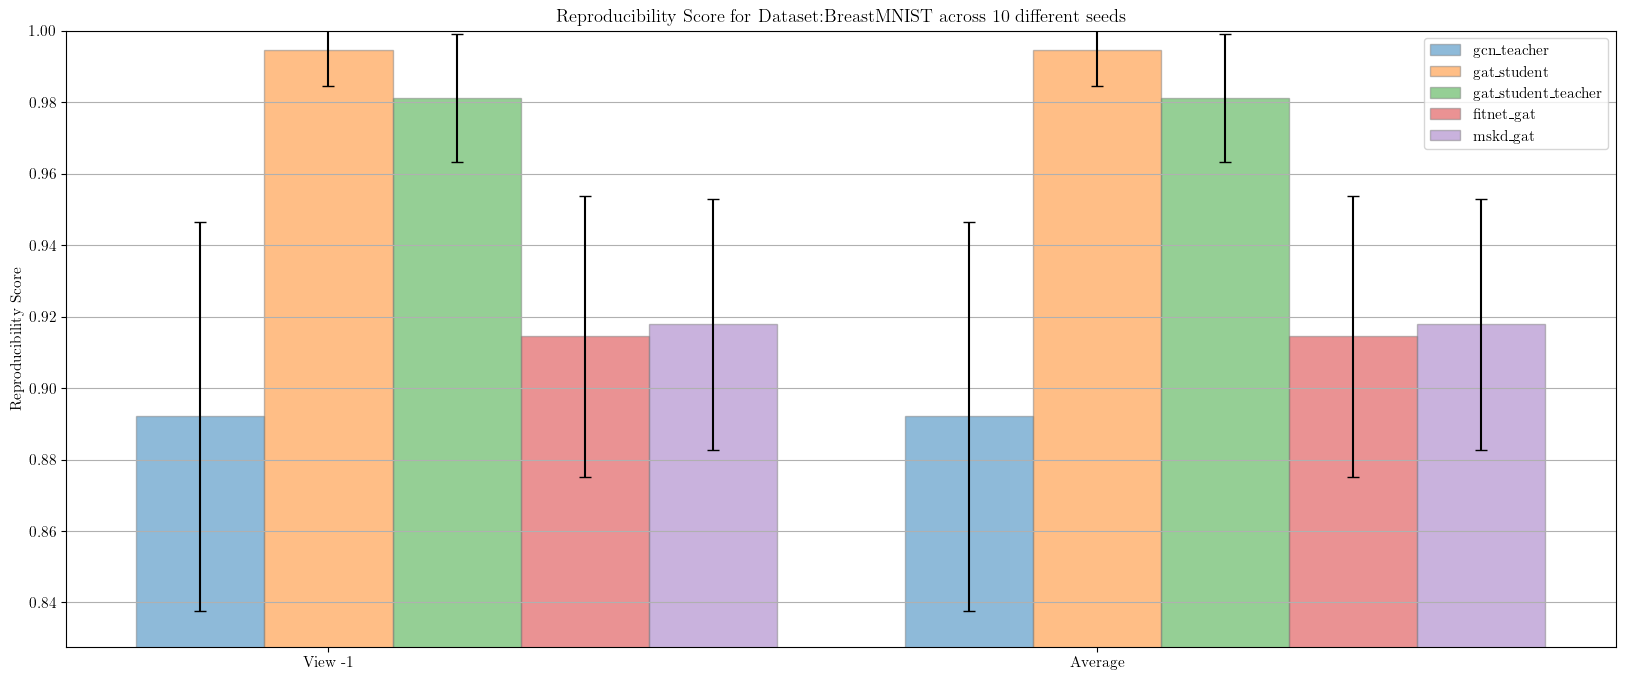

<Figure size 2000x800 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {
    'text.usetex' : True,
    'font.size' : 11,
    'font.family' :'lmodern'
}
plt.rcParams.update(params)

dataset="BreastMNIST"
views=[-1]
models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat", "mskd_gat"]
model_args = [
    gcn_BreastMNIST_args, 
    gat_gat_student_BreastMNIST_args, 
    gcn_gat_student_BreastMNIST_args, 
    gcn_gat_fitnet_student_BreastMNIST_args,
    gcn_gat_mskd_student_BreastMNIST_args
]
CV=["3Fold", "5Fold", "10Fold"]
runs=[i for i in range(10)]
save_fig=False

plot_bar_chart_reproducibility_mulitple_runs(dataset, views, models, CV, runs, students=[-1,-1,-1,-1,-1,-1,-1], model_args=model_args, save_fig=False)

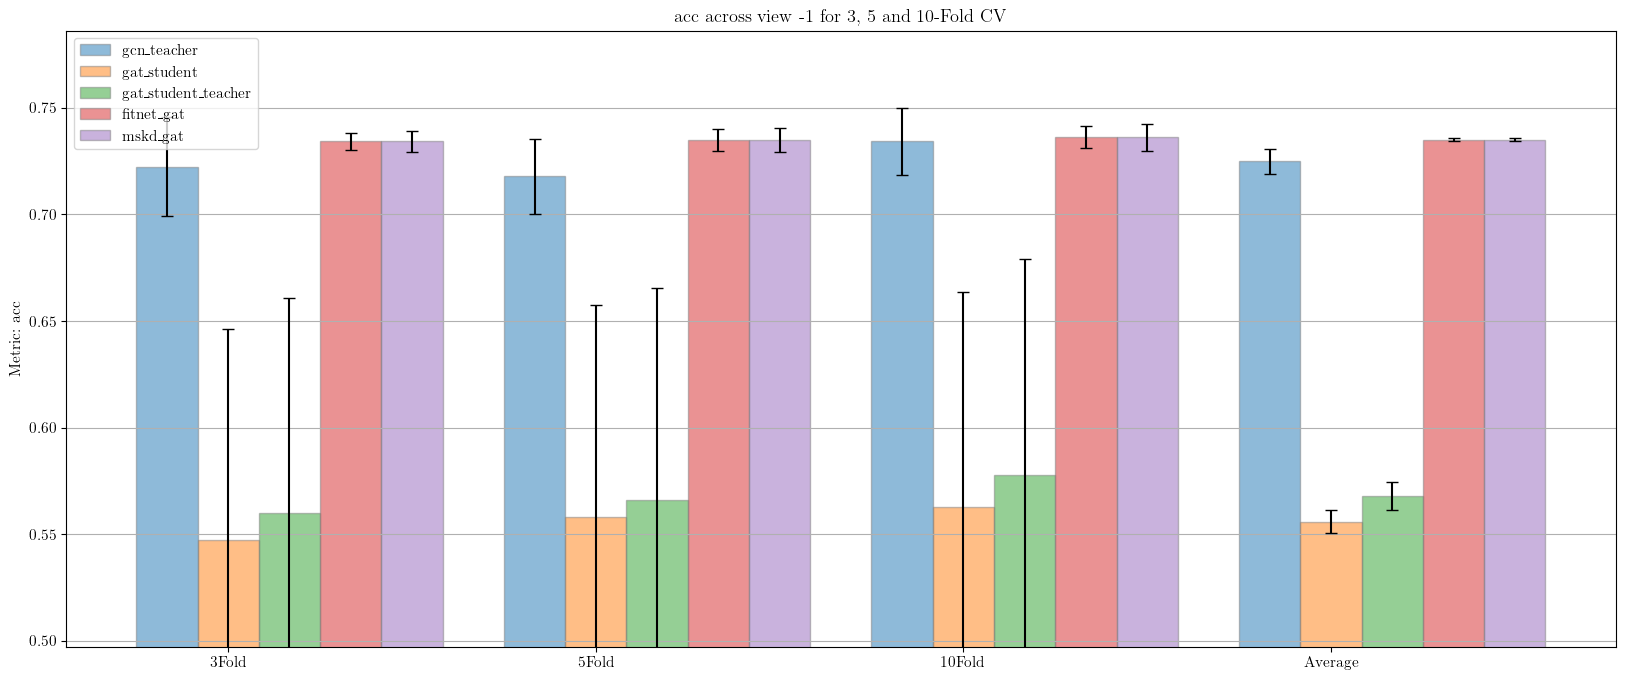

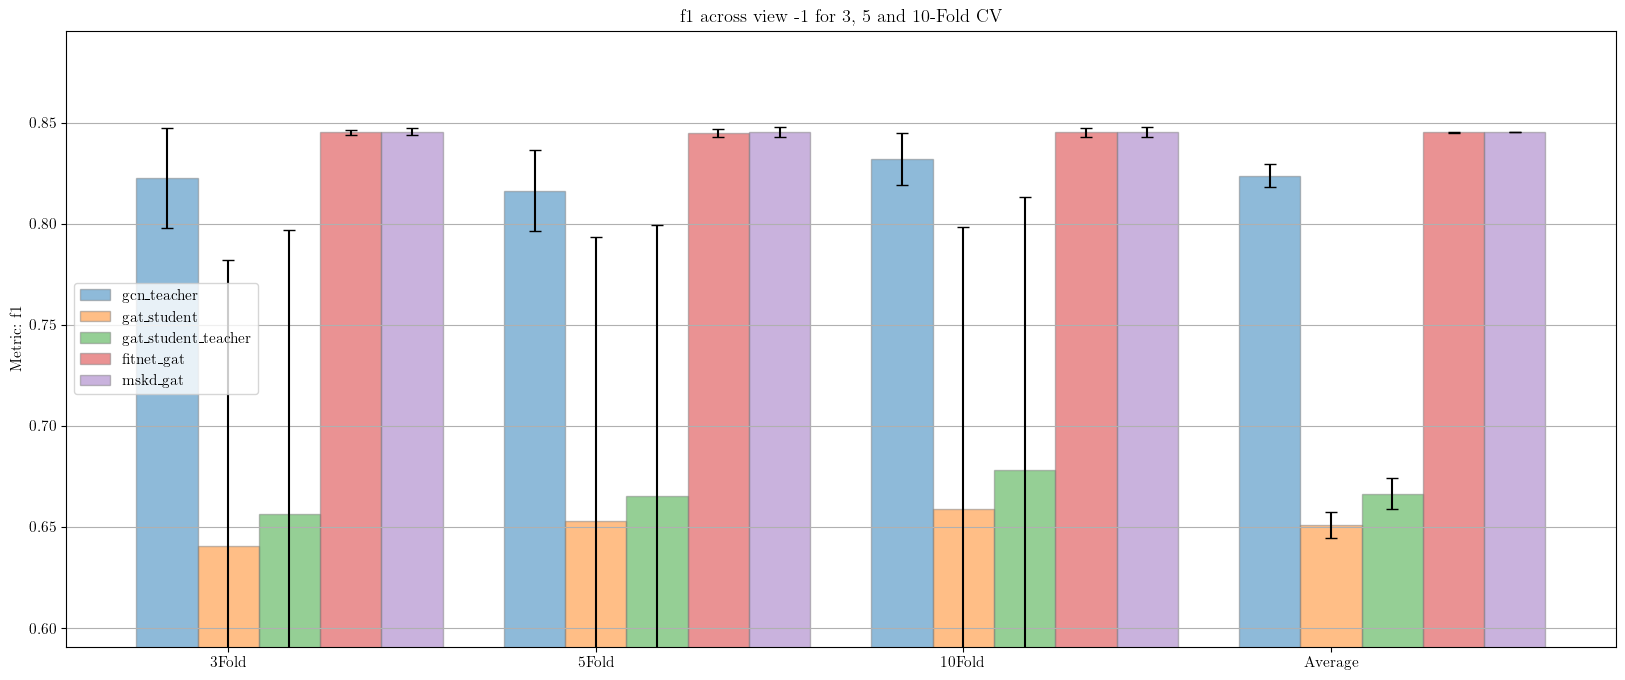

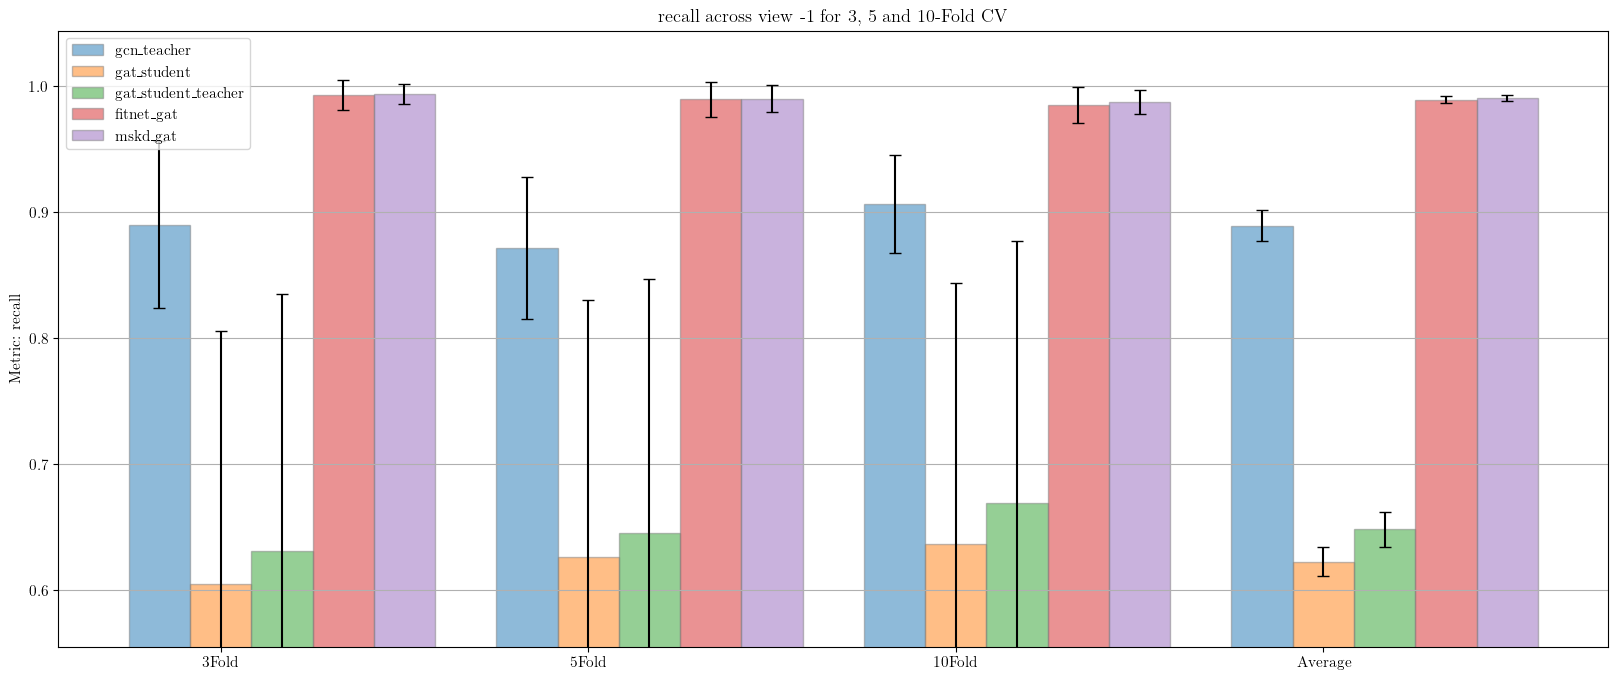

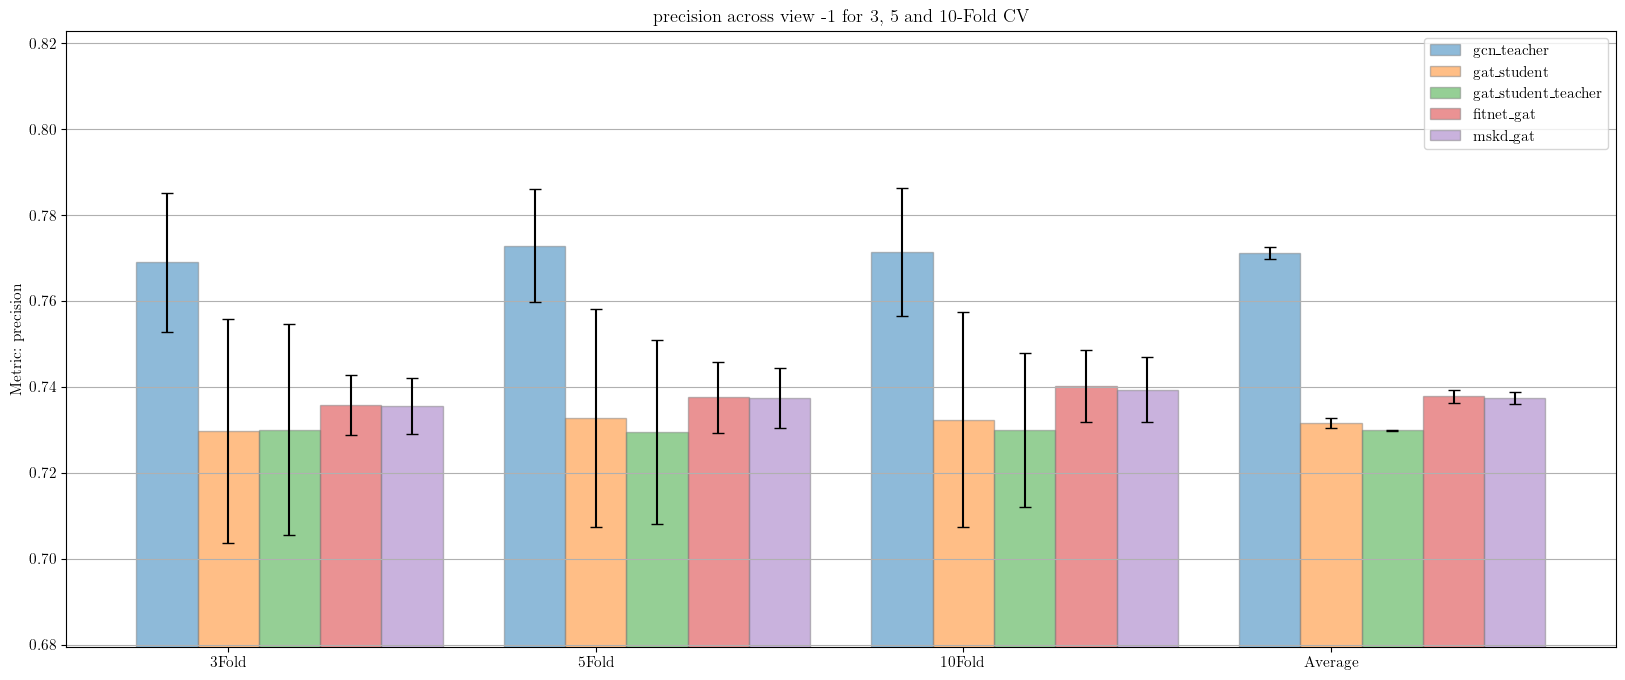

<Figure size 2000x800 with 0 Axes>

In [11]:
for view in [-1]:
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="acc", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="f1", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="recall", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)
    plot_bar_chart_metric_multiple_runs(dataset="BreastMNIST", view=view, models=models, CV=["3Fold", "5Fold", "10Fold"], runs=runs, metric="precision", model_args=model_args, dataset_split="val", analysis_type="model_assessment", save_fig=False)


# GAT ANALYSIS

In [13]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [14]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [35]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [15]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [16]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [19]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [20]:
analysis_type="model_assessment"
dataset_split="val"
dataset = "BreastMNIST"
CV=["3Fold", "5Fold", "10Fold"]

models_args=[
    gcn_gat_student_lsp_ensamble_2_BreastMNIST_args,
    gcn_gat_student_lsp_ensamble_3_BreastMNIST_args,
    gcn_gat_student_lsp_ensamble_4_BreastMNIST_args,
    gcn_gat_student_lsp_ensamble_5_BreastMNIST_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    mean, var, best_students = get_best_student_ensamble_detailed(
        model=model_arg["model_name"], 
        view=-1, 
        CV=CV,
        dataset=dataset,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=model_arg
    )
    print(best_students)
    all_model_metrics_mean.append(mean)
    all_model_metrics_var.append(var)
    all_model_best_student.append(best_students)


gat_student_lsp_ensamble_2
[[0.9633333333333333, 9.305555555555621e-05, 0], [0.9633333333333333, 9.305555555555621e-05, 0], [0.9633333333333333, 9.305555555555621e-05, 0], [0.9633333333333333, 9.305555555555621e-05, 0], [0.9633333333333333, 9.305555555555621e-05, 0]]
gat_student_lsp_ensamble_3
[[0.9369444444444446, 0.00043873456790123583, 2], [0.9269444444444446, 8.032407407407345e-05, 0], [0.9269444444444446, 8.032407407407345e-05, 0], [0.9279166666666667, 0.0004955439814814816, 1], [0.9269444444444446, 8.032407407407345e-05, 0]]
gat_student_lsp_ensamble_4
[[0.9552777777777777, 0.00040462962962962924, 1], [0.953888888888889, 0.0003861111111111093, 0], [0.953888888888889, 0.0003861111111111093, 0], [0.9552777777777777, 0.00040462962962962924, 1], [0.953888888888889, 0.0003861111111111093, 0]]
gat_student_lsp_ensamble_5
[[0.9576388888888887, 0.0002427662037037044, 2], [0.9275000000000002, 0.0007383487654321014, 0], [0.9275000000000002, 0.0007383487654321014, 0], [0.9479166666666666, 0.0

In [21]:
df_best_student = np.array(all_model_best_student)
df_metrics_var = np.array(all_model_metrics_var)
df_model_mean = np.array(all_model_metrics_mean)

In [25]:
df_model_mean[0][0], df_metrics_var[0][0], df_best_student[0]

(array([0.73978632, 0.84777865, 0.99163743, 0.74046179]),
 array([1.73314340e-06, 3.10355416e-07, 3.69686399e-06, 2.30196767e-06]),
 array([[9.63333333e-01, 9.30555556e-05, 0.00000000e+00],
        [9.63333333e-01, 9.30555556e-05, 0.00000000e+00],
        [9.63333333e-01, 9.30555556e-05, 0.00000000e+00],
        [9.63333333e-01, 9.30555556e-05, 0.00000000e+00],
        [9.63333333e-01, 9.30555556e-05, 0.00000000e+00]]))

In [26]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="BreastMNIST", 
    views=[-1], 
    models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat", "mskd_gat", "gat_student_lsp_ensamble_2"],
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [0]
    ], 
    model_args = [
    gcn_BreastMNIST_args, 
    gat_gat_student_BreastMNIST_args, 
    gcn_gat_student_BreastMNIST_args, 
    gcn_gat_fitnet_student_BreastMNIST_args,
    gcn_gat_mskd_student_BreastMNIST_args,
    gcn_gat_student_lsp_ensamble_2_BreastMNIST_args
    ])

In [31]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat", "mskd_gat", "gat_student_lsp_ensamble_2"]
reproducibility_frame.columns = models

reproducibility_frame["delta vanilla"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["gat_student_teacher"]) / reproducibility_frame["gat_student_teacher"])*100
reproducibility_frame["delta fitnet"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["fitnet_gat"]) / reproducibility_frame["fitnet_gat"])*100
#reproducibility_frame["delta lsp"] = ((reproducibility_frame["gcn_student_lsp_ensamble_3"] - reproducibility_frame["lsp_gcn"]) / reproducibility_frame["lsp_gcn"])*100
reproducibility_frame["delta mskd"] = ((reproducibility_frame["gat_student_lsp_ensamble_2"] - reproducibility_frame["mskd_gat"]) / reproducibility_frame["mskd_gat"])*100

In [32]:
reproducibility_frame

,gcn,gat_student,gat_student_teacher,fitnet_gat,mskd_gat,gat_student_lsp_ensamble_2,delta vanilla,delta fitnet,delta mskd
0,0.892083,0.994722,0.981111,0.914444,0.917917,0.963333,-1.812005,5.346294,4.947798
1,0.892083,0.994722,0.981111,0.914444,0.917917,0.963333,-1.812005,5.346294,4.947798


In [36]:
views=[-1]
CV=["3Fold", "5Fold", "10Fold"]
#model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
model = ["gat_student_lsp_ensamble_2"]
runs = [i for i in range(10)]
dataset = "BreastMNIST"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= [gcn_gat_student_lsp_ensamble_2_BreastMNIST_args]

best_student = [0]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gat_student", "gat_student_teacher", "fitnet_gat", "mskd_gat"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, 
                                                 model_args= [
                                                    gcn_BreastMNIST_args, 
                                                    gat_gat_student_BreastMNIST_args, 
                                                    gcn_gat_student_BreastMNIST_args, 
                                                    gcn_gat_fitnet_student_BreastMNIST_args,
                                                    gcn_gat_mskd_student_BreastMNIST_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

____________________________________________________
View: -1 Metric: acc


In [37]:
models=["gcn", "gat_student", "gat_student_teacher", "fitnet_gat", "mskd_gat", "gat_student_lsp_ensamble_2"]
average_across_views_df = pd.DataFrame(view_mean[0][:,-1])
average_across_views_df_mean = average_across_views_df.T

average_across_views_df_mean.columns = models
average_across_views_df_mean

average_across_views_df_mean["delta vanilla"] = ((average_across_views_df_mean["gat_student_lsp_ensamble_2"] - average_across_views_df_mean["gat_student_teacher"]) / average_across_views_df_mean["gat_student_teacher"])*100
average_across_views_df_mean["delta fitnet"] = ((average_across_views_df_mean["gat_student_lsp_ensamble_2"] - average_across_views_df_mean["fitnet_gat"]) / average_across_views_df_mean["fitnet_gat"])*100
#average_across_views_df_mean["delta lsp"] = ((average_across_views_df_mean["gat_student_lsp_ensamble_2"] - average_across_views_df_mean["lsp_gcn"]) / average_across_views_df_mean["lsp_gcn"])*100
average_across_views_df_mean["delta mskd"] = ((average_across_views_df_mean["gat_student_lsp_ensamble_2"] - average_across_views_df_mean["mskd_gat"]) / average_across_views_df_mean["mskd_gat"])*100
average_across_views_df_mean

,gcn,gat_student,gat_student_teacher,fitnet_gat,mskd_gat,gat_student_lsp_ensamble_2,delta vanilla,delta fitnet,delta mskd
0,0.724829,0.555897,0.567863,0.735085,0.735128,0.739786,30.275436,0.639498,0.633647
